In [ ]:
import pandas as pd
import gzip
import array
import numpy as np
import networkx as nx

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
from collections import deque
from scipy.sparse import coo, coo_matrix

In [ ]:
import matplotlib.pyplot as plt

# Data utils

In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

def readImageFeatures(path):
  f = open(path, 'rb')
  while True:
    asin = f.read(10)
    if asin == '': break
    a = array.array('f')
    try:
      a.fromfile(f, 4096)
    except:
      break
    yield asin, a.tolist()

def related_convert_to_list(x):
  r = set([])
  if x.isna()['related']:
    return r
  else:
    x = x['related']
    for key in x:
      for item in x[key]:
        r.add(item)
    return r

## Musical Instruments

In [ ]:
category = 'Musical_Instruments'

In [ ]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Musical_Instruments.csv
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Musical_Instruments.json.gz
# !wget http://snap.stanford.edu/data/amazon/productGraph/image_features/categoryFiles/image_features_Musical_Instruments.b

--2021-06-30 02:49:29--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Musical_Instruments.csv
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20376609 (19M) [text/csv]
Saving to: ‘ratings_Musical_Instruments.csv’

ratings_Musical_Ins 100%[===================>]  19.43M  11.4MB/s    in 1.7s    

2021-06-30 02:49:31 (11.4 MB/s) - ‘ratings_Musical_Instruments.csv’ saved [20376609/20376609]

--2021-06-30 02:49:31--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Musical_Instruments.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30816870 (29M) [application/x-gzip]
Saving to: ‘meta_Musical_Instruments.json.gz’

meta_Musical_Instru 10

In [ ]:
ratings_df = pd.read_csv('ratings_{}.csv'.format(category), header=None)
ratings_df[2] = ratings_df[2].apply(lambda x: x / 5)
ratings_df

,0,1,2,3
0,A1YS9MDZP93857,0006428320,0.6,1394496000
1,A3TS466QBAWB9D,0014072149,1.0,1370476800
2,A3BUDYITWUSIS7,0041291905,1.0,1381708800
3,A19K10Z0D2NTZK,0041913574,1.0,1285200000
4,A14X336IB4JD89,0201891859,0.2,1350432000
...,...,...,...,...
500171,A2XEVARMJP81E,B00LIR7QNS,1.0,1405641600
500172,A3PAQGM6P87MXO,B00LJD5AUM,1.0,1404518400
500173,A2KZX7A4XZ4T2W,B00LK7A9SK,1.0,1404518400
500174,AIDHT6KXOL64T,SMLRBIMX03,1.0,1355788800


In [ ]:
len(set(ratings_df[0]))

339231

Include buyers that have purchased at least 3 products

In [ ]:
ratings_df = ratings_df[ratings_df.groupby(0)[1].transform('count')>3]
ratings_df = ratings_df.reset_index(drop=True)

In [ ]:
ratings_df

,0,1,2,3
0,A1YS9MDZP93857,0006428320,0.6,1394496000
1,A3TS466QBAWB9D,0014072149,1.0,1370476800
2,A2HR0IL3TC4CKL,0577088726,1.0,1371168000
3,AXMWZYP2IROMP,0634029355,0.4,1352419200
4,A1M7OWNI93N1Y3,0634029363,0.4,1365897600
...,...,...,...,...
111658,AU4HC1AD4LE3E,B00KQ7Y2AQ,1.0,1404345600
111659,ACDXZ39D2FL13,B00KVVNWP8,1.0,1404432000
111660,A15HOKGIHN0XNG,B00KVWRBTK,1.0,1405123200
111661,A2NYK9KWFMJV4Y,B00KWIMAGC,1.0,1404777600


In [ ]:
ratings_df_index = {id:i for i,id in enumerate(ratings_df[0])}

In [ ]:
ratings_df_reviewer = ratings_df.set_index(0)
ratings_df_asin = ratings_df.set_index(1)

In [ ]:
ratings_df_index = {id:i for i,id in enumerate(ratings_df[0])}

In [ ]:
meta_df = getDF('meta_{}.json.gz'.format(category))
meta_df = meta_df[['asin', 'related']]
meta_df = meta_df.set_index('asin')
meta_df = meta_df.apply(lambda x: related_convert_to_list(x), axis=1)
meta_df

asin
0006428320                                                   {}
0014072149                                         {B0058DK7RA}
0041291905                                                   {}
0041913574                                                   {}
0201891859                                                   {}
                                    ...                        
B00LEWRD80    {B007NMZ64S, B007PR4ZFM, B004MZG1IO, B007NM952...
B00LIR7QNS    {B00502E892, B005KYUETS, B00LIR3SK8, B0002F7C5...
B00LJD5AUM                                                   {}
B00LK7A9SK                                                   {}
SMLRBIMX03    {B001E95KGK, B003VXNPN2, B000K112K6, B006X4VNS...
Length: 84901, dtype: object

# Data exploration

In [ ]:
def add_to_queue_or_graph(Q, G, source, to_add, indicator, depth):
        if isinstance(to_add, str):
            if to_add not in G._node:
                Q.append((to_add, indicator, depth))
            else:
                G.add_edge(source, to_add)
        else:
            for t in to_add:
                add_to_queue_or_graph(Q, G, source, t, indicator, depth)

In [ ]:
def get_graph_around_user(user, max_depth):
      '''
      Return a adjacency matrix and feature matrix of graph surrounding the user
      '''
      G = nx.Graph()
      Q = deque()
      Q.append((user, 0, 0)) # 0 user, 0 for depth
      idx = 0

      while Q:
          node_name, node_type, depth = Q.popleft()
          if depth > max_depth: break

          if node_name not in G._node:
              G.add_node(node_name)

          if node_type == 0: # User
              products = ratings_df_reviewer.loc[node_name][1]
              add_to_queue_or_graph(Q, G, node_name, products, 1, depth+1)

          else:
              if node_name in meta_df.index:
                  products = meta_df.loc[node_name]
                  add_to_queue_or_graph(Q, G, node_name, products, 1, depth+1)

              if node_name in ratings_df_asin.index:
                  users = ratings_df_asin.loc[node_name][0]
                  add_to_queue_or_graph(Q, G, node_name, users, 0, depth+1)

      return G.number_of_nodes()

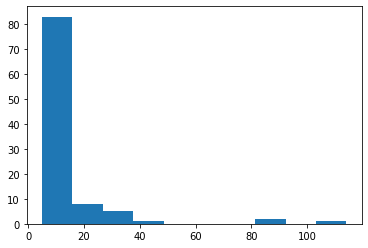

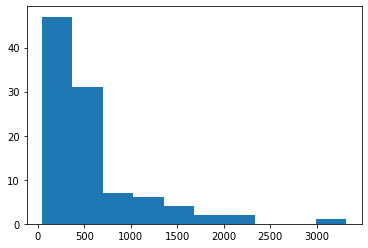

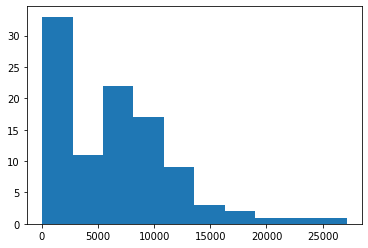

In [ ]:
number_of_nodes = {}
for max_depth in range(1, 4):
  number_of_nodes[max_depth] = []
  for user in tqdm(ratings_df_reviewer.index[:100]):
    number_of_nodes[max_depth].append(get_graph_around_user(user, max_depth))
  plt.hist(number_of_nodes[max_depth])
  plt.show()

In [ ]:
pd.DataFrame(number_of_nodes).describe()

,1,2,3
count,100.000000,100.000000,100.000000
mean,12.200000,571.960000,6548.400000
std,16.729578,533.220517,5332.258587
min,5.000000,45.000000,45.000000
25%,5.000000,270.000000,1863.000000
50%,6.000000,406.500000,6442.000000
75%,11.250000,648.500000,9032.500000
max,114.000000,3321.000000,27123.000000


In [ ]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Movies_and_TV.csv

In [ ]:
movies_ratings_df = pd.read_csv('ratings_Movies_and_TV.csv', header = None)

In [ ]:
# Number of common customers ordering both categories
print(len(set(ratings_df[0]).intersection(movies_ratings_df[0])))

In [ ]:
# Number of customers ordering category products (in total)
len(set(ratings_df[0]))